In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Agricultural-crops",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 73 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Coffee-plant', 'cotton', 'maize']

In [6]:
for image_batch, labels_batch in dataset.take(0):
    print(image_batch.shape)
    print(labels_batch.numpy())

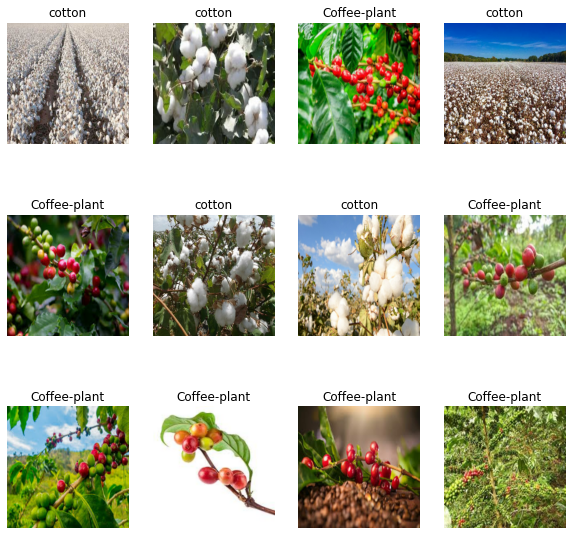

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

3

In [9]:
train_size = 0.8
len(dataset)*train_size

2.4000000000000004

In [10]:
train_ds = dataset.take(54)
len(train_ds)

3

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

0.30000000000000004

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

2

In [18]:
len(val_ds)

0

In [19]:
len(test_ds)

1

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
2/2 [==============================] - 10s 4s/step - loss: 1.0971 - accuracy: 0.3906
Epoch 2/50
2/2 [==============================] - 8s 4s/step - loss: 1.0672 - accuracy: 0.3750
Epoch 3/50
2/2 [==============================] - 8s 4s/step - loss: 1.0512 - accuracy: 0.3906
Epoch 4/50
2/2 [==============================] - 8s 4s/step - loss: 1.0401 - accuracy: 0.5156
Epoch 5/50
2/2 [==============================] - 8s 4s/step - loss: 0.9896 - accuracy: 0.4375
Epoch 6/50
2/2 [==============================] - 8s 4s/step - loss: 0.9333 - accuracy: 0.5781
Epoch 7/50
2/2 [==============================] - 8s 4s/step - loss: 0.8522 - accuracy: 0.6094
Epoch 8/50
2/2 [==============================] - 8s 4s/step - loss: 0.8446 - accuracy: 0.5625
Epoch 9/50
2/2 [==============================] - 8s 4s/step - loss: 0.7541 - accuracy: 0.6094
Epoch 10/50
2/2 [==============================] - 8s 4s/step - loss: 0.6984 - accuracy: 0.5781
Epoch 11/50
2/2 [==============================]

In [68]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Agricultural-crops"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [30]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.2666 - accuracy: 1.0000


In [31]:
scores

[0.26656919717788696, 1.0]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 2}

In [40]:
#history.history.keys()

history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0971158742904663,
 1.0671799182891846,
 1.0511711835861206,
 1.0400530099868774,
 0.9895780086517334]

first image to predict
actual label: cotton
1/1 [==============================] - 0s 485ms/step
predicted label: cotton


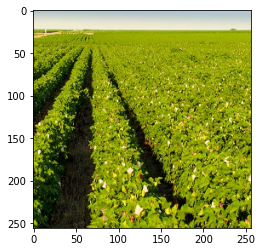

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


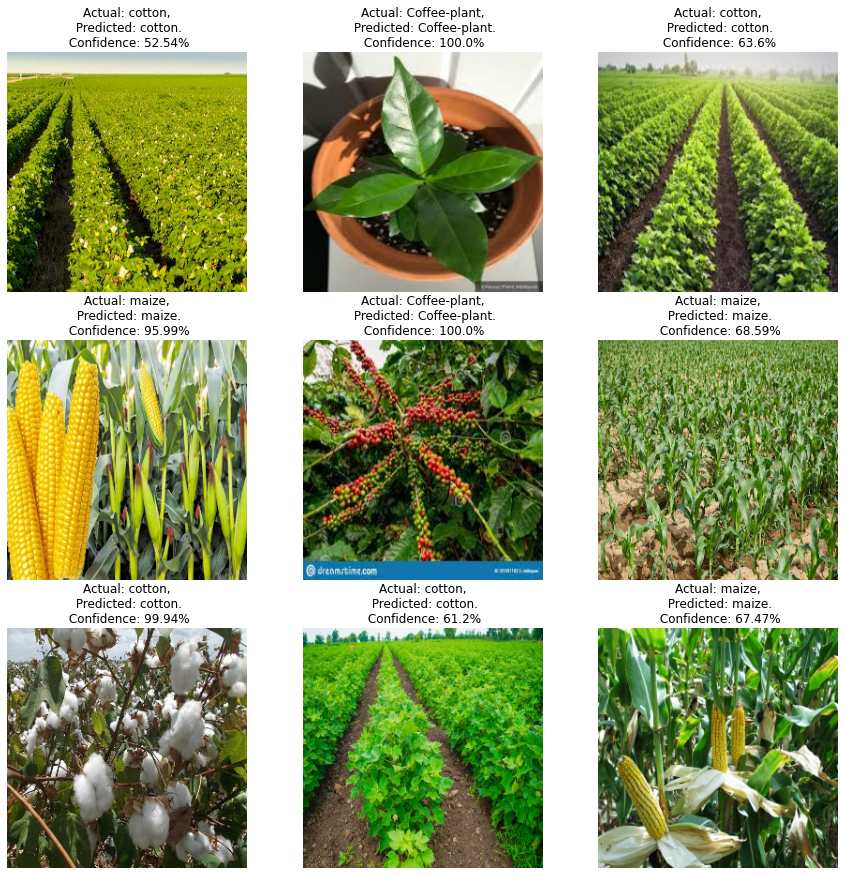

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [47]:
model.save('./models', save_format='tf')

In [48]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 5.2 MB/s 
     |████████████████████████████████| 55 kB 895 kB/s 
     |████████████████████████████████| 2.3 MB 31.2 MB/s 
     |████████████████████████████████| 213 kB 42.1 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 106 kB 54.0 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 278 kB 52.9 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 80 kB 7.1 MB/s 
     |████████████████████████████████| 68 kB 6.7 MB/s 
     |████████████████████████████████| 68 kB 5.8 MB/s 
     |████████████████████████████████| 68 kB 5.9 MB/s 
     |████████████████████████████████| 68 kB 6.7 M

In [49]:
import gradio as gr

In [54]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [55]:
image = gr.inputs.Image(shape=(256,256))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 53ms/step
Keyboard interruption in main thread... closing server.
